# ITALY COVID-19 DATA ANALYSIS

In this jupyter notebook, we'll try analyse italian COVID-19 data gathered from *Dipartimento di Protezione Civile* GitHub repository ([link](https://github.com/pcm-dpc/COVID-19)).

We'll first create $x$ axes with datetime objects and $y$ axes with daily variations of
- confirmed cases
- recoveries
- deaths
- infected

where _infected_ are equal to _confirmed - (recoverd + deaths)_.

We won't reject outliers not to loose any data, nor standardize or normalize data but we'll try to work with rough data only.
We'll try to fit _confirmed_, _deaths_ and _recoverd_ to gaussian curves (prime derivatives of the logistic growth curves) and calculate new infected curve from them.
We'll then try to get a forecast up to as many days as the period covered by gathered data.

In [1]:
%matplotlib notebook

import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit, brentq
import numpy as np

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

First, let's define the gaussian function we'll use to fit data $$y = a \mathbf{e}^{ -(x-b)^2 / c^2}$$

In [2]:
def gauss_func(x, a, b, c):
    d = - ((x - b) ** 2)
    return a * np.exp( d / (c ** 2) )

and get the most recently updated data from D.P.C. GitHub repository, loading them into a dictionary:

In [3]:
json_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
with requests.get(json_ita) as req:
    data = json.loads(req.content.decode('utf-8-sig'))

Let's check the dates of the downloaded data:

In [4]:
print("FIRST ENTRY DATE: {}".format(data[0]["data"].replace("T", " ")))

print("LAST  ENTRY DATE: {}".format(data[-1]["data"].replace("T", " ")))

period = (
    dt.datetime.strptime(data[-1]["data"], "%Y-%m-%dT%H:%M:%S") -
    dt.datetime.strptime(data[0]["data"], "%Y-%m-%dT%H:%M:%S")
).days

print("COVERAGE: {} days".format(period))

print("CURRENT DATE IS:  {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

FIRST ENTRY DATE: 2020-02-24 18:00:00
LAST  ENTRY DATE: 2020-04-03 17:00:00
COVERAGE: 38 days
CURRENT DATE IS:  2020-04-03 23:54:06


Now, let's initialize $x$ and $y$ variables (we'll need also integer $x$ array to perform `curve_fit`)

In [5]:
x = []   # datetime x array
_x = []  # integer x array
yC = []  # new confirmed cases array
yD = []  # new deaths array
yR = []  # new recovered array
yP = []  # new infected array

TOTyC = []  # new confirmed cases array
TOTyD = []  # new deaths array
TOTyR = []  # new recovered array
TOTyP = []  # new infected array

For each data entry:
- append datetime object to `x`
- append integer to `_x`
- append new cases to $y$

We'll skip `data[0]` and get the first difference from `data[1]` on

In [6]:
for i, day in enumerate(data):
    if not i:
        pre = day
        continue
    date = dt.datetime.strptime(day["data"], "%Y-%m-%dT%H:%M:%S")
    # x values
    x.append(date)
    _x.append(i)
    # y values
    yC.append(day["totale_casi"] - pre["totale_casi"])
    yD.append(day["deceduti"] - pre["deceduti"])
    yR.append(day["dimessi_guariti"] - pre["dimessi_guariti"])
    yP.append(day["variazione_totale_positivi"])
    # y TOT values
    TOTyC.append(day["totale_casi"])
    TOTyD.append(day["deceduti"])
    TOTyR.append(day["dimessi_guariti"])
    TOTyP.append(day["totale_positivi"])
    
    pre = day

Let's take a look to gathered data

<IPython.core.display.Javascript object>


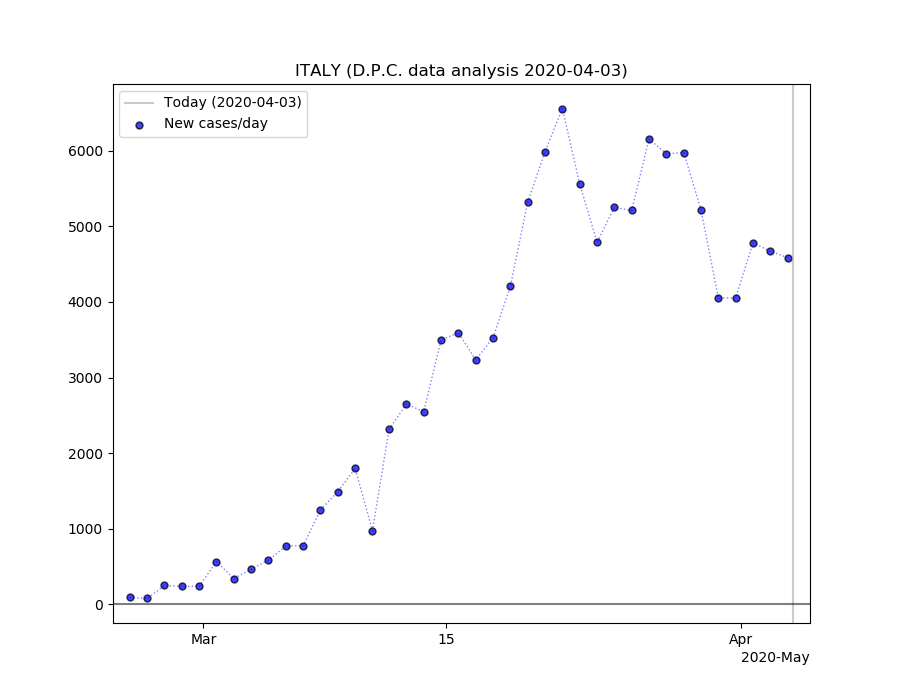

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="#0000ff",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


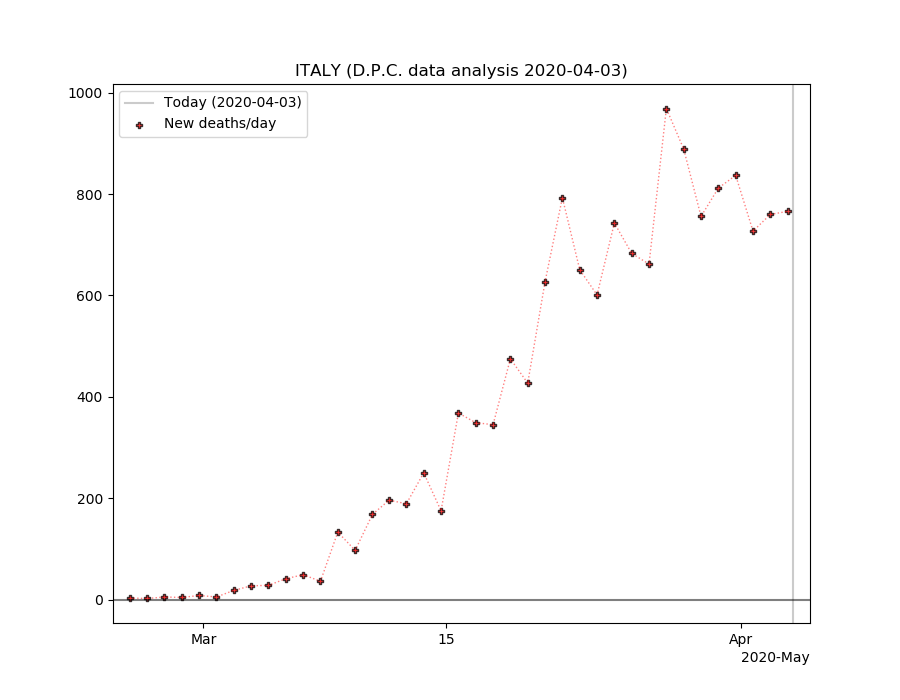

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="P", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


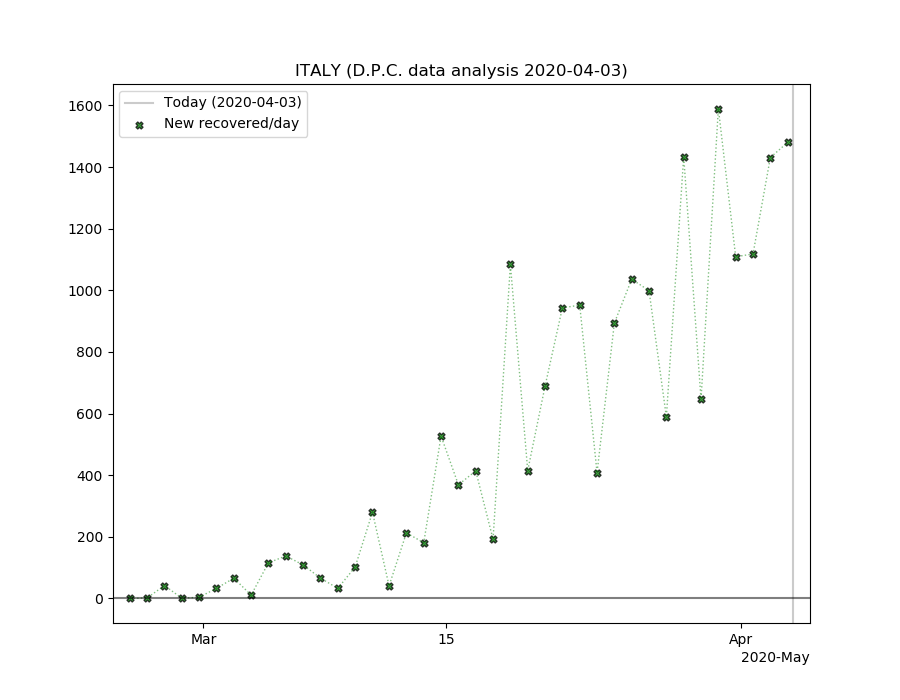

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="X", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


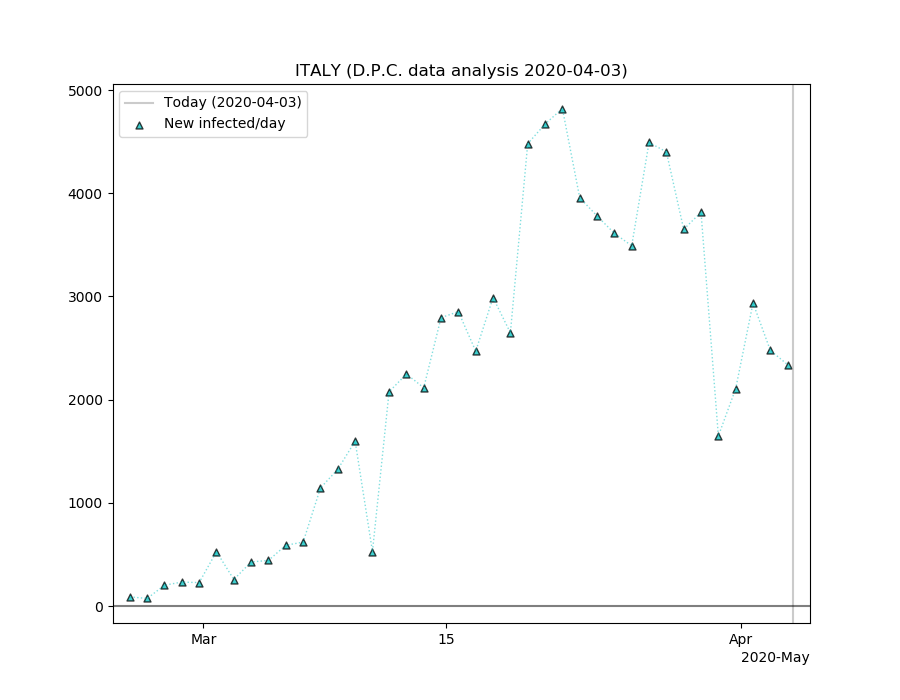

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

Let's now perform the `curve_fit` to the gaussian function with the known values (using integer array values `_x` instead of datetime `x`) to get `popt = (a, b, c)` parameters for each curve, guessing the maximum value of $y$ for $a$ parameter.
We'll also want get the `pcov` covariance of the fitted parameters and calculate the standard error `perr` we'll use later to plot standard error bands.

In [11]:
poptC, pcovC = curve_fit(gauss_func, _x, yC, p0=[max(yC), 1, 1])  # returns (a, b, c)
perrC = np.sqrt(np.diag(pcovC))
eSupC = poptC + perrC
eInfC = poptC - perrC

poptD, pcovD = curve_fit(gauss_func, _x, yD, p0=[max(yD), 1, 1])  # returns (a, b, c)
perrD = np.sqrt(np.diag(pcovD))
eSupD = poptD + perrD
eInfD = poptD - perrD

poptR, pcovR = curve_fit(gauss_func, _x, yR, p0=[max(yR), 1, 1])  # returns (a, b, c)
perrR = np.sqrt(np.diag(pcovR))
eSupR = poptR + perrR
eInfR = poptR - perrR

Here's what we found out

In [12]:
print("CONFIRMED")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptC[0], perrC[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptC[1], perrC[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptC[2]), perrC[2])))

CONFIRMED


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
print("DEATHS")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptD[0], perrD[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptD[1], perrD[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptD[2]), perrD[2])))

DEATHS


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
print("RECOVERED")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptR[0], perrR[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptR[1], perrR[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptC[2]), perrR[2])))

RECOVERED


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's now prepare `xg` array (datetime objects) and `_xg` array (integer values) for the forecast. We'll forecast for as many days of gathered data `period`, from the last day `x[-1]`.

In [15]:
print("Forecast up to: {}".format(x[-1] + dt.timedelta(days=period + 1)))

# forecast x datetime objects
xg = [x[-1] + dt.timedelta(days=d + 1) for d in range(period)]
xg = x + xg
# forecast x integer values
_xg = [_x[-1] + d + 1 for d in range(period)]
_xg = _x + _xg

Forecast up to: 2020-05-12 17:00:00


Let's get the $y$ values of the gaussian curves and their lower/upper standard error, till the end of the forecast.

In [16]:
yCg = gauss_func(_xg, *poptC)
yCgSup = gauss_func(_xg, *eSupC)
yCgInf = gauss_func(_xg, *eInfC)

yDg = gauss_func(_xg, *poptD)
yDgSup = gauss_func(_xg, *eSupD)
yDgInf = gauss_func(_xg, *eInfD)

yRg = gauss_func(_xg, *poptR)
yRgSup = gauss_func(_xg, *eSupR)
yRgInf = gauss_func(_xg, *eInfR)

# infected = confirmed - (deaths + recovered)
yPg = yCg - (yDg + yRg)
yPgSup = yCgSup - (yDgSup + yRgSup)
yPgInf = yCgInf - (yDgInf + yRgInf)

Let's take a look to fitted gaussian curves with standard error bands

<IPython.core.display.Javascript object>


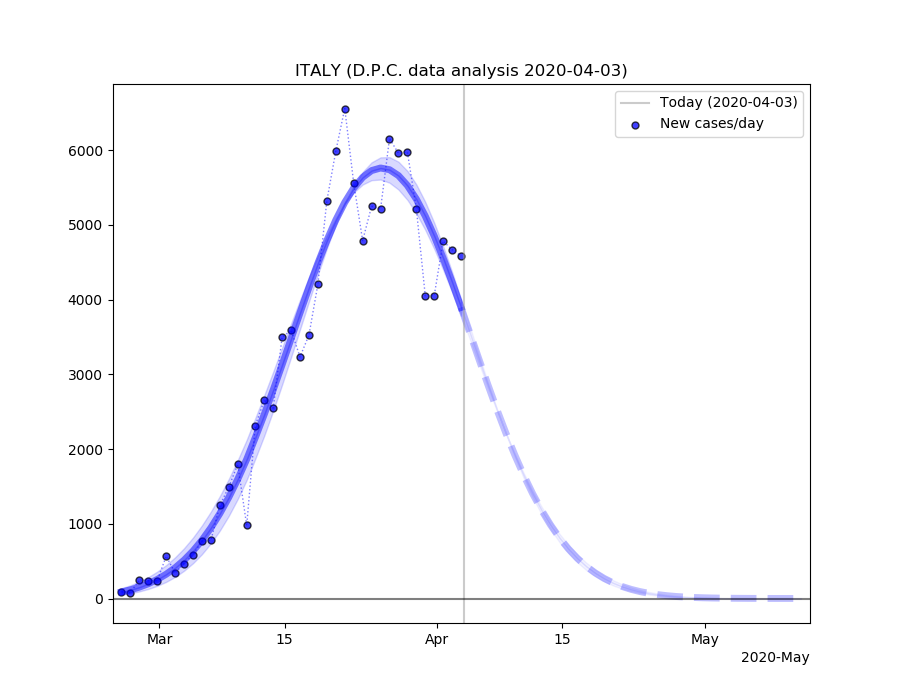

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)

# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.05, color="b")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


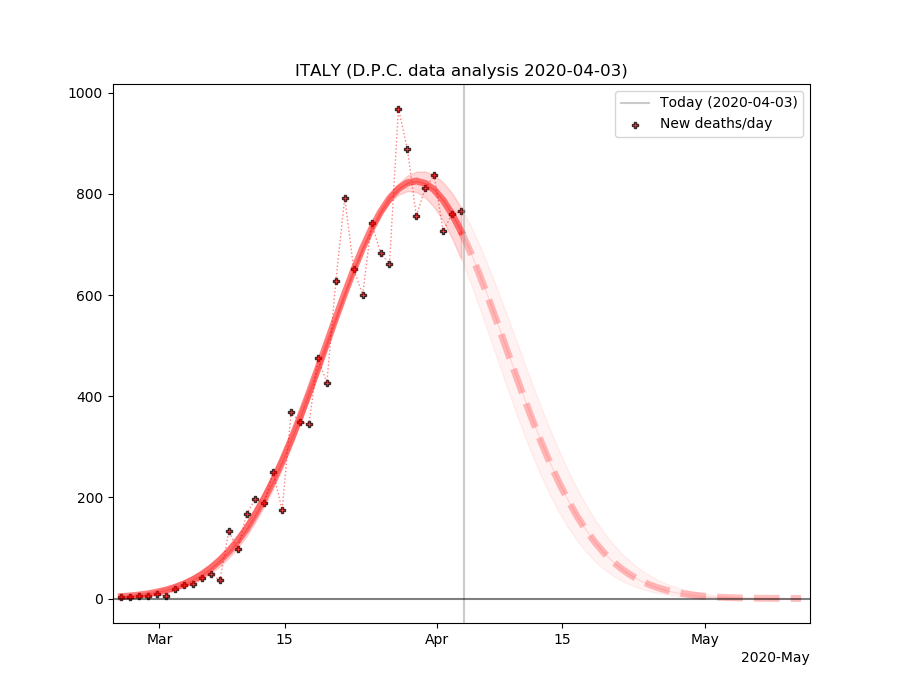

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="P", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)

# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.05, color="r")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


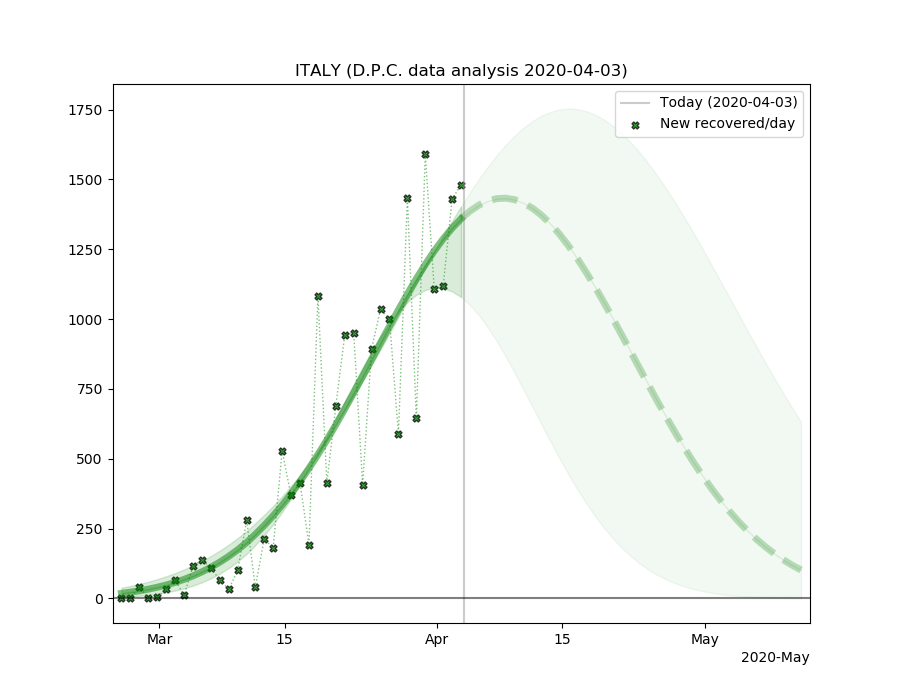

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="X", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)

# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.05, color="g")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


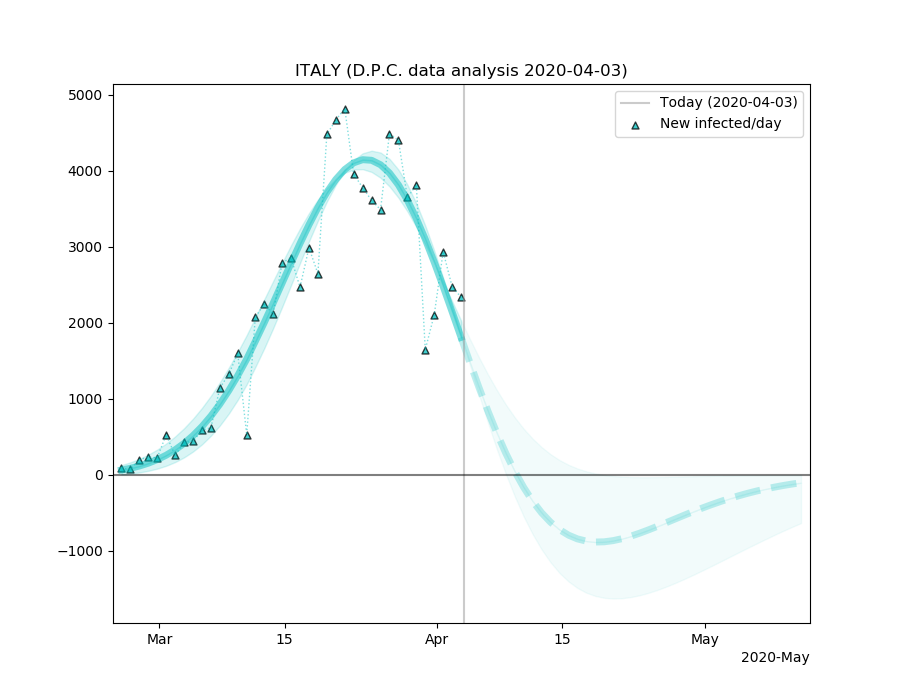

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)

# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yPg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yPg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgSup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgSup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgInf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgInf[len(x) - 1:], alpha=0.05, color="c")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

For each $y$ array, let's now get
- the maximum $[x_{max}, y_{max}]$ coordinates and its standard error
  - in the standard gaussian curve, maximum coordinates are $[\mu, f(\mu)]$, in our gaussian function will then be $[b, f(b)]$ so we need to add $b - 1$ days to first $x_0$ date ($b - 1$ and not $b$ because we skeepped $x_0$) and calculate $y_{max} = f(b)$ with known parameters $(a, b, c)$
- the flexes $[x_{flex}, y_{flex}]$ coordinates and their standard error
  - the two flexes will obiviously be $[b-\sigma, f(b-\sigma)]$ and $[b+\sigma, f(b+\sigma)]$, so we first need to calculate $\sigma$ (the standard deviation):
    - $\sigma$ in our gaussian curve is equal to $c/\sqrt{2}$
- the guessed _~0 events/day_ and its standard error i.e. the day we could expect to have _almost_ no new event per day. We could choose this day as $\mu$ (the maximum, $b$) + three standard deviations $x_{0 cases} = b + 3\sigma$

In [21]:
# CONFIRMED CASES
a, b, c = poptC
aSup, bSup, cSup = poptC + perrC
aInf, bInf, cInf = poptC - perrC
# the maximum x coordinate, datetime object
muC = x[0] + dt.timedelta(days=abs(b) - 1)
muCsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muCinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muC = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuC = gauss_func(_muC, *poptC)
# calculate sigma
siC = abs(c / np.sqrt(2))
siCsup = abs(cSup / np.sqrt(2))
siCinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1C = muC - dt.timedelta(days=siC)
f1Csup = muCsup - dt.timedelta(days=siCsup)
f1Cinf = muCinf - dt.timedelta(days=siCinf)
yf1C = gauss_func(_muC - siC, *poptC)
# 2nd flex coordinates
f2C = muC + dt.timedelta(days=siC)
f2Csup = muCsup + dt.timedelta(days=siCsup)
f2Cinf = muCinf + dt.timedelta(days=siCinf)
yf2C = gauss_func(_muC + siC, *poptC)
# x coordinate of ~0 events/day
noC = muC + dt.timedelta(days=(3 * siC))
noCsup = muCsup + dt.timedelta(days=(3 * siCsup))
noCinf = muCinf + dt.timedelta(days=(3 * siCinf))

Let's do the same for the other curves

In [22]:
# DEATHS
a, b, c = poptD
aSup, bSup, cSup = poptD + perrD
aInf, bInf, cInf = poptD - perrD
# the maximum x coordinate, datetime object
muD = x[0] + dt.timedelta(days=abs(b) - 1)
muDsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muDinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muD = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuD = gauss_func(_muD, *poptD)
# calculate sigma
siD = abs(c / np.sqrt(2))
siDsup = abs(cSup / np.sqrt(2))
siDinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1D = muD - dt.timedelta(days=siD)
f1Dsup = muDsup - dt.timedelta(days=siDsup)
f1Dinf = muDinf - dt.timedelta(days=siDinf)
yf1D = gauss_func(_muD - siD, *poptD)
# 2nd flex coordinates
f2D = muD + dt.timedelta(days=siD)
f2Dsup = muDsup + dt.timedelta(days=siDsup)
f2Dinf = muDinf + dt.timedelta(days=siDinf)
yf2D = gauss_func(_muD + siD, *poptD)
# x coordinate of ~0 events/day
noD = muD + dt.timedelta(days=(3 * siD))
noDsup = muDsup + dt.timedelta(days=(3 * siDsup))
noDinf = muDinf + dt.timedelta(days=(3 * siDinf))

# RECOVERED
a, b, c = poptR
aSup, bSup, cSup = poptR + perrR
aInf, bInf, cInf = poptR - perrR
# the maximum x coordinate, datetime object
muR = x[0] + dt.timedelta(days=abs(b) - 1)
muRsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muRinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muR = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuR = gauss_func(_muR, *poptR)
# calculate sigma
siR = abs(c / np.sqrt(2))
siRsup = abs(cSup / np.sqrt(2))
siRinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1R = muR - dt.timedelta(days=siR)
f1Rsup = muRsup - dt.timedelta(days=siRsup)
f1Rinf = muRinf - dt.timedelta(days=siRinf)
yf1R = gauss_func(_muR - siR, *poptR)
# 2nd flex coordinates
f2R = muR + dt.timedelta(days=siR)
f2Rsup = muRsup + dt.timedelta(days=siRsup)
f2Rinf = muRinf + dt.timedelta(days=siRinf)
yf2R = gauss_func(_muR + siR, *poptR)
# x coordinate of ~0 events/day
noR = muR + dt.timedelta(days=(3 * siR))
noRsup = muRsup + dt.timedelta(days=(3 * siRsup))
noRinf = muRinf + dt.timedelta(days=(3 * siRinf))

For infected, we'll need to solve the equation
$$ 0 = f(x)_{Confirmed} -  \Bigg(  f(x)_{Deaths} + f(x)_{Recovered} \Bigg) $$
to get the root, i.e. the day of 0 new infected/day, the day from which
$$ \mathbf{new}_{confirmed} < (\mathbf{new}_{deaths} + \mathbf{new}_{recovered}) $$

And we'll need to do this for lower/upper standard errors too:

In [23]:
# INFECTED
def infected_func(x):
    return gauss_func(x, *poptC) - (gauss_func(x, *poptD) + gauss_func(x, *poptR))


def infected_func_sup(x):
    return gauss_func(x, *eSupC) - (gauss_func(x, *eSupD) + gauss_func(x, *eSupR))


def infected_func_inf(x):
    return gauss_func(x, *eInfC) - (gauss_func(x, *eInfD) + gauss_func(x, *eInfR))


_x0P = brentq(infected_func, _xg[0], _xg[-1])
x0P = xg[0] + dt.timedelta(days=_x0P - 1)

_x0Psup = brentq(infected_func_sup, _xg[0], _xg[-1])
x0Psup = xg[0] + dt.timedelta(days=_x0Psup - 1)

_x0Pinf = brentq(infected_func_inf, _xg[0], _xg[-1])
x0Pinf = xg[0] + dt.timedelta(days=_x0Pinf - 1)

In [24]:
print("NO NEW INFECTED/DAY:\nlo: {}\nmi: {}\nup: {}".format(x0Psup, x0P, x0Pinf))

NO NEW INFECTED/DAY:
lo: 2020-04-08 19:11:10.453860
mi: 2020-04-09 23:05:28.484035
up: 2020-04-19 17:32:06.469423


Let's look each single plot with maximum, flexes and guessed ~0 events/day dates

<IPython.core.display.Javascript object>


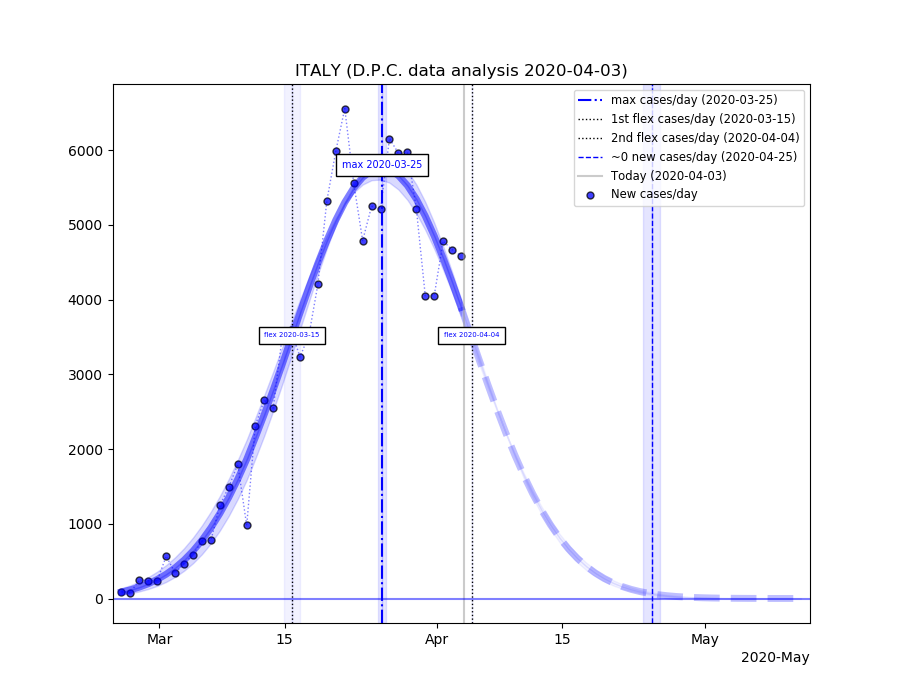

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noC) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.05, color="b")
# maximum and flexes
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
ax.axvspan(muC, muCsup, alpha=0.1, color="b")
ax.axvspan(muC, muCinf, alpha=0.1, color="b")
plt.text(muC, ymuC, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f1C, linestyle=":", color="k", label="1st flex cases/day ({})".format(f1C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1C, f1Csup, alpha=0.05, color="b")
ax.axvspan(f1C, f1Cinf, alpha=0.05, color="b")
plt.text(f1C, yf1C, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f2C, linestyle=":", color="k", label="2nd flex cases/day ({})".format(f2C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2C, f2Csup, alpha=0.05, color="b")
ax.axvspan(f2C, f2Cinf, alpha=0.05, color="b")
plt.text(f2C, yf2C, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

# ~0 cases/day date vertical line 
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))
ax.axvspan(noC, noCsup, alpha=0.1, color="b")
ax.axvspan(noC, noCinf, alpha=0.1, color="b")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="b", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


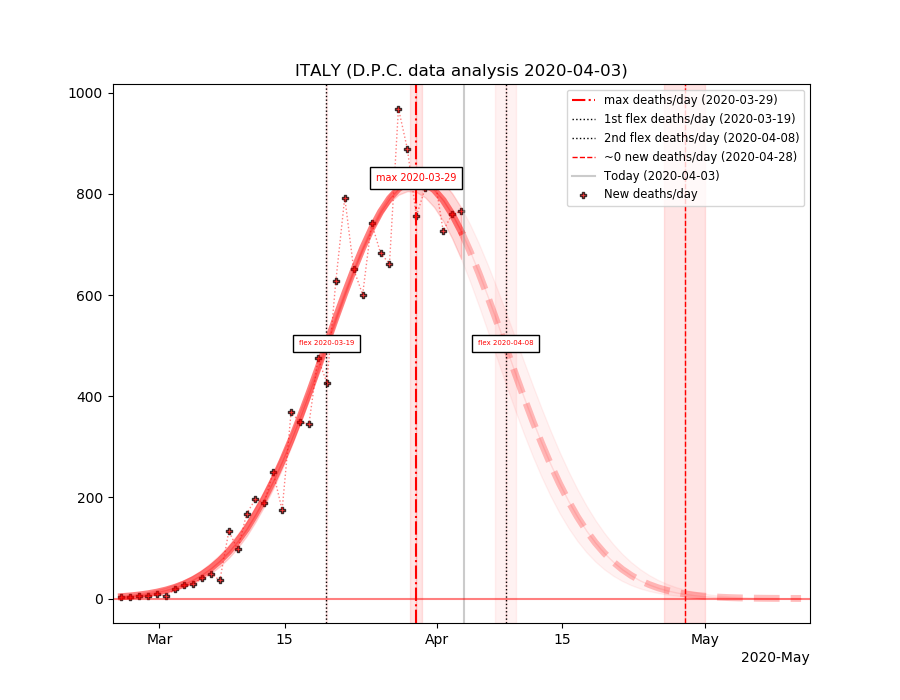

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noD) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="P", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.05, color="r")
# maximum and flexes
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
ax.axvspan(muD, muDsup, alpha=0.1, color="r")
ax.axvspan(muD, muDinf, alpha=0.1, color="r")
plt.text(muD, ymuD, "max " + muD.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f1D, linestyle=":", color="k", label="1st flex deaths/day ({})".format(f1D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1D, f1Dsup, alpha=0.05, color="r")
ax.axvspan(f1D, f1Dinf, alpha=0.05, color="r")
plt.text(f1D, yf1D, "flex " + f1D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f2D, linestyle=":", color="k", label="2nd flex deaths/day ({})".format(f2D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2D, f2Dsup, alpha=0.05, color="r")
ax.axvspan(f2D, f2Dinf, alpha=0.05, color="r")
plt.text(f2D, yf2D, "flex " + f2D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

# ~0 deaths/day date vertical line 
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))
ax.axvspan(noD, noDsup, alpha=0.1, color="r")
ax.axvspan(noD, noDinf, alpha=0.1, color="r")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="r", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


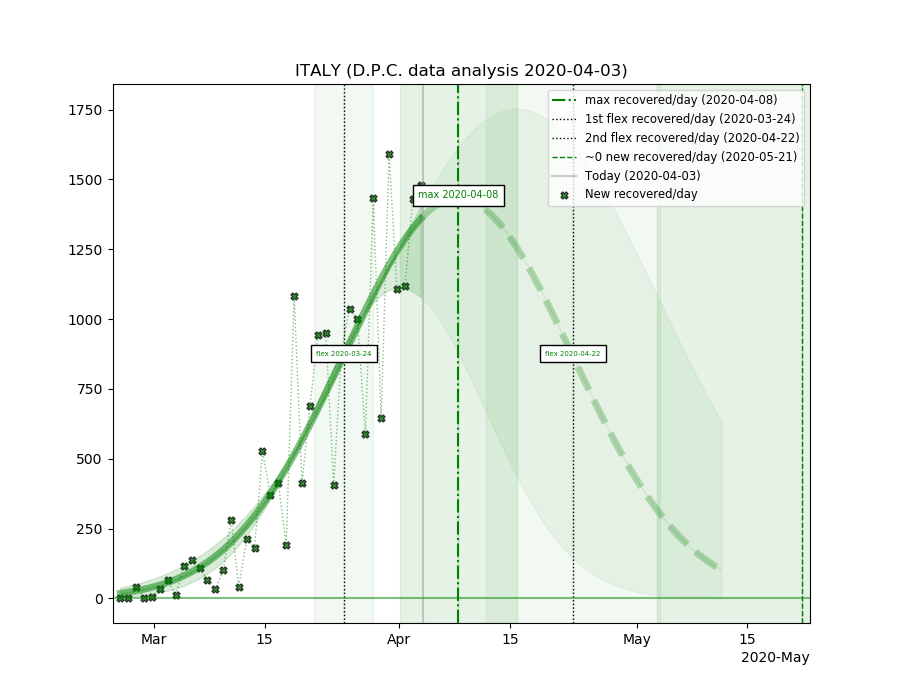

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noR) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="X", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.05, color="g")
# maximum and flexes
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
ax.axvspan(muR, muRsup, alpha=0.1, color="g")
ax.axvspan(muR, muRinf, alpha=0.1, color="g")
plt.text(muR, ymuR, "max " + muR.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f1R, linestyle=":", color="k", label="1st flex recovered/day ({})".format(f1R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1R, f1Rsup, alpha=0.05, color="g")
ax.axvspan(f1R, f1Rinf, alpha=0.05, color="g")
plt.text(f1R, yf1R, "flex " + f1R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f2R, linestyle=":", color="k", label="2nd flex recovered/day ({})".format(f2R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2R, f2Rsup, alpha=0.05, color="g")
ax.axvspan(f2R, f2Rinf, alpha=0.05, color="g")
plt.text(f2R, yf2R, "flex " + f2R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

# ~0 recovered/day date vertical line 
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))
ax.axvspan(noR, noRsup, alpha=0.1, color="g")
ax.axvspan(noR, noRinf, alpha=0.1, color="g")

# TORAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="g", alpha=0.5)

# LEGENR
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


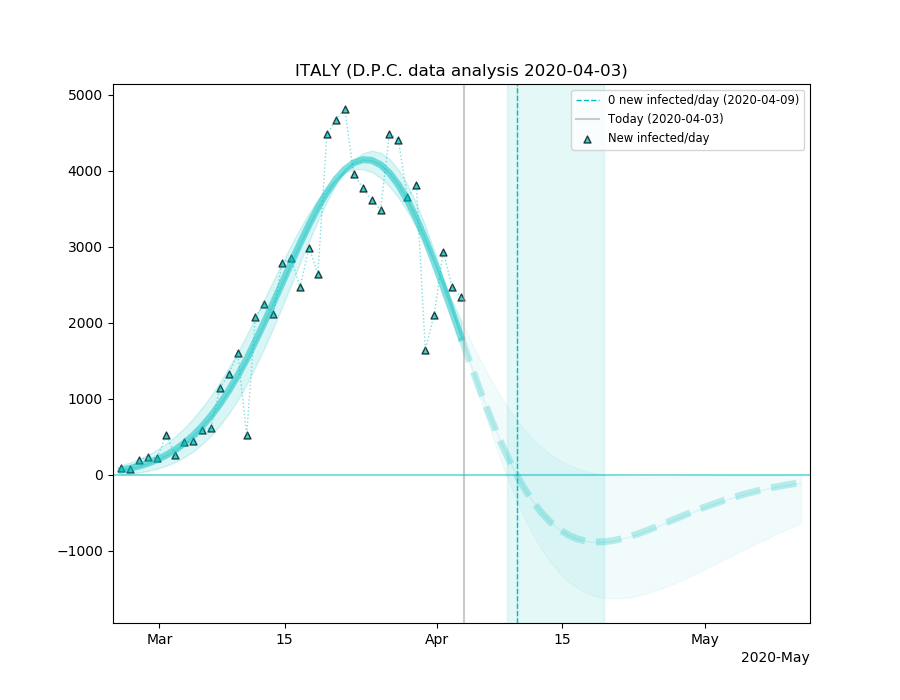

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yCg[:len(x)] - yDg[:len(x)] - yRg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:] - yDg[len(x) - 1:] - yRg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)


ax.fill_between(xg[:len(x)],
                yCg[:len(x)] - yDg[:len(x)] - yRg[:len(x)],
                yCgSup[:len(x)] - yDgSup[:len(x)] - yRgSup[:len(x)],
                alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], 
                yCg[len(x) - 1:] - yDg[len(x) - 1:] - yRg[len(x) - 1:],
                yCgSup[len(x) - 1:] - yDgSup[len(x) - 1:] - yRgSup[len(x) - 1:], 
                alpha=0.05, color="c")

ax.fill_between(xg[:len(x)],
                yCg[:len(x)] - yDg[:len(x)] - yRg[:len(x)],
                yCgInf[:len(x)] - yDgInf[:len(x)] - yRgInf[:len(x)],
                alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], 
                yCg[len(x) - 1:] - yDg[len(x) - 1:] - yRg[len(x) - 1:],
                yCgInf[len(x) - 1:] - yDgInf[len(x) - 1:] - yRgInf[len(x) - 1:], 
                alpha=0.05, color="c")

# ~0 infected/day date vertical line 
plt.axvline(x=x0P, color="c", linestyle="--", linewidth=1.0, label="0 new infected/day ({})".format(x0P.strftime("%Y-%m-%d")))
ax.axvspan(x0P, x0Psup, alpha=0.1, color="c")
ax.axvspan(x0P, x0Pinf, alpha=0.1, color="c")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="c", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

And finally take a look to the complete result, hiding original data, flexes and vertical error bands

<IPython.core.display.Javascript object>


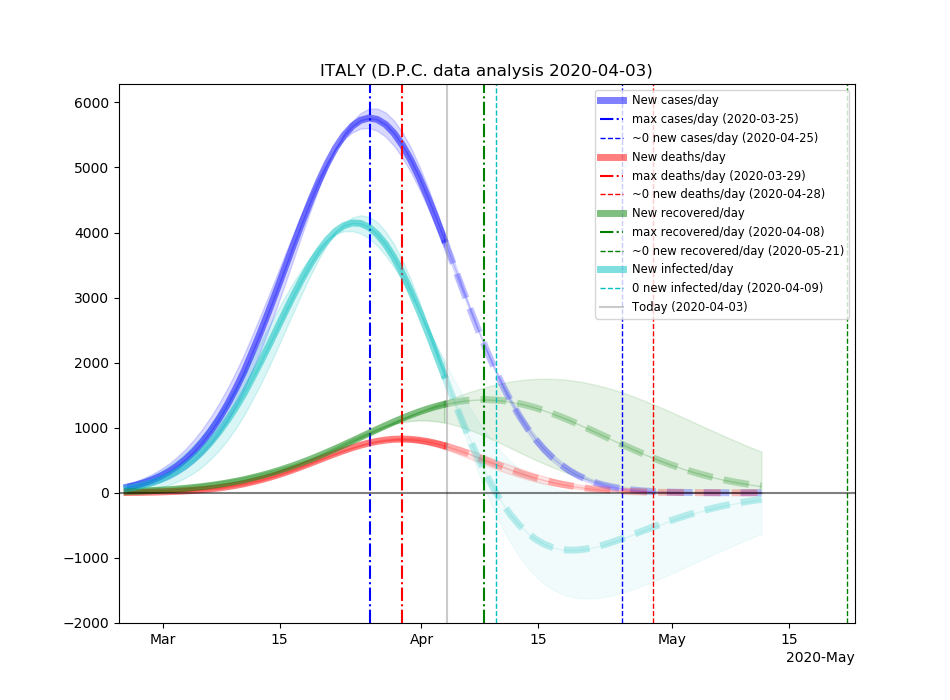

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9.5, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noC, noD, noR) + dt.timedelta(days=1))

# CONFIRMED
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0, label="New cases/day")
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.1, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.1, color="b")
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))

# DEATHS
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0, label="New deaths/day")
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.1, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.1, color="r")
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))

# RECOVERED
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0, label="New recovered/day")
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.1, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.1, color="g")
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))

# INFECTED
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yPg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0, label="New infected/day")
ax.plot(xg[len(x) - 1:], yPg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgSup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgSup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgInf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgInf[len(x) - 1:], alpha=0.05, color="c")
plt.axvline(x=x0P, color="c", linestyle="--", linewidth=1.0, label="0 new infected/day ({})".format(x0P.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

Now we can try to get the logistic curves of _confirmed_, _deaths_ and _recovered_ and the asymmetric gaussian of _infected_.

In [30]:
# CONFIRMED
logC = []
for i, y in enumerate(yCg):
    if not i:
        logC.append(y)
        continue
    logC.append(y + logC[i - 1])
logCsup = []
for i, y in enumerate(yCgSup):
    if not i:
        logCsup.append(y)
        continue
    logCsup.append(y + logCsup[i - 1])
logCinf = []
for i, y in enumerate(yCgInf):
    if not i:
        logCinf.append(y)
        continue
    logCinf.append(y + logCinf[i - 1])

In [31]:
# DEATHS
logD = []
for i, y in enumerate(yDg):
    if not i:
        logD.append(y)
        continue
    logD.append(y + logD[i - 1])
logDsup = []
for i, y in enumerate(yDgSup):
    if not i:
        logDsup.append(y)
        continue
    logDsup.append(y + logDsup[i - 1])
logDinf = []
for i, y in enumerate(yDgInf):
    if not i:
        logDinf.append(y)
        continue
    logDinf.append(y + logDinf[i - 1])

In [32]:
# RECOVERED
logR = []
for i, y in enumerate(yRg):
    if not i:
        logR.append(y)
        continue
    logR.append(y + logR[i - 1])
logRsup = []
for i, y in enumerate(yRgSup):
    if not i:
        logRsup.append(y)
        continue
    logRsup.append(y + logRsup[i - 1])
logRinf = []
for i, y in enumerate(yRgInf):
    if not i:
        logRinf.append(y)
        continue
    logRinf.append(y + logRinf[i - 1])

In [33]:
# INFECTED
logP = []
for i, y in enumerate(yPg):
    if not i:
        logP.append(y)
        continue
    logP.append(y + logP[i - 1])
logPsup = []
for i, y in enumerate(yPgSup):
    if not i:
        logPsup.append(y)
        continue
    logPsup.append(y + logPsup[i - 1])
logPinf = []
for i, y in enumerate(yPgInf):
    if not i:
        logPinf.append(y)
        continue
    logPinf.append(y + logPinf[i - 1])

<IPython.core.display.Javascript object>


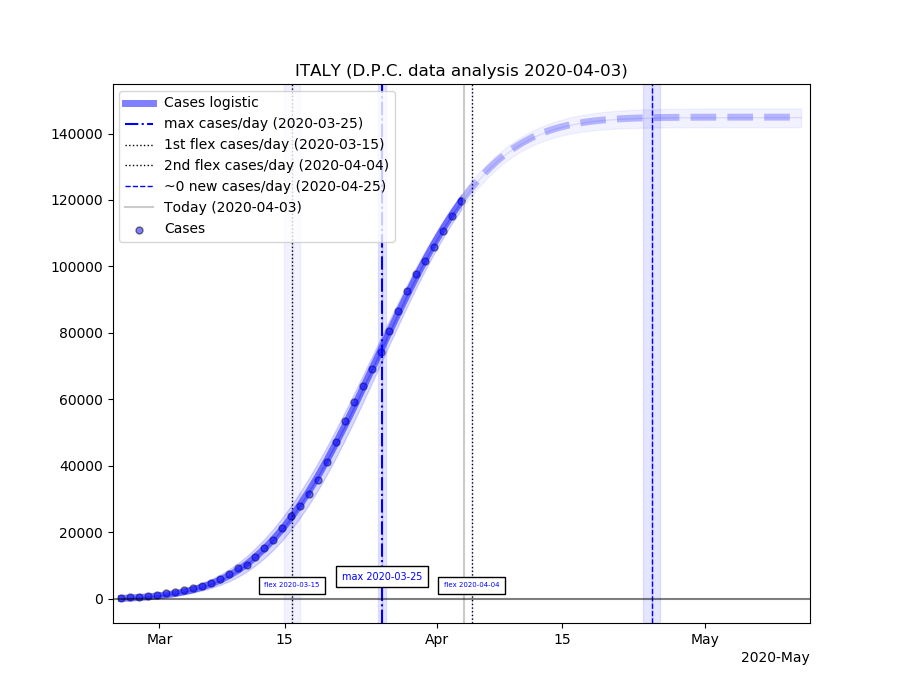

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, TOTyC, alpha=0.5, c="b",edgecolors='#000000', marker="o", s=25, label="Cases")
# original data dotted line
# ax.plot(x, TOTyC, alpha=0.35, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], logC[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0, label="Cases logistic")
ax.plot(xg[len(x) - 1:], logC[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logC[:len(x)], logCsup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], logC[len(x) - 1:], logCsup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], logC[:len(x)], logCinf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], logC[len(x) - 1:], logCinf[len(x) - 1:], alpha=0.05, color="b")

# maximum and flexes
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
ax.axvspan(muC, muCsup, alpha=0.1, color="b")
ax.axvspan(muC, muCinf, alpha=0.1, color="b")
plt.text(muC, ymuC, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f1C, linestyle=":", color="k", label="1st flex cases/day ({})".format(f1C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1C, f1Csup, alpha=0.05, color="b")
ax.axvspan(f1C, f1Cinf, alpha=0.05, color="b")
plt.text(f1C, yf1C, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f2C, linestyle=":", color="k", label="2nd flex cases/day ({})".format(f2C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2C, f2Csup, alpha=0.05, color="b")
ax.axvspan(f2C, f2Cinf, alpha=0.05, color="b")
plt.text(f2C, yf2C, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

# ~0 cases/day date vertical line 
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))
ax.axvspan(noC, noCsup, alpha=0.1, color="b")
ax.axvspan(noC, noCinf, alpha=0.1, color="b")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


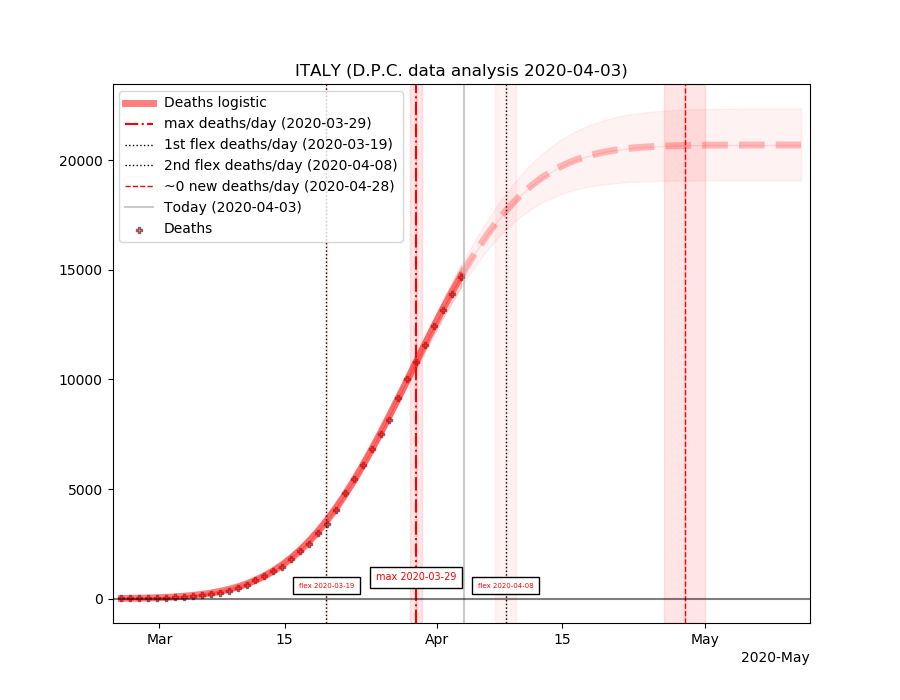

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, TOTyD, alpha=0.5, c="r",edgecolors='#000000', marker="P", s=25, label="Deaths")
# original data dotted line
# ax.plot(x, TOTyD, alpha=0.35, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], logD[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0, label="Deaths logistic")
ax.plot(xg[len(x) - 1:], logD[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logD[:len(x)], logDsup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], logD[len(x) - 1:], logDsup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], logD[:len(x)], logDinf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], logD[len(x) - 1:], logDinf[len(x) - 1:], alpha=0.05, color="r")

# maximum and flexes
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
ax.axvspan(muD, muDsup, alpha=0.1, color="r")
ax.axvspan(muD, muDinf, alpha=0.1, color="r")
plt.text(muD, ymuD, "max " + muD.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f1D, linestyle=":", color="k", label="1st flex deaths/day ({})".format(f1D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1D, f1Dsup, alpha=0.05, color="r")
ax.axvspan(f1D, f1Dinf, alpha=0.05, color="r")
plt.text(f1D, yf1D, "flex " + f1D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f2D, linestyle=":", color="k", label="2nd flex deaths/day ({})".format(f2D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2D, f2Dsup, alpha=0.05, color="r")
ax.axvspan(f2D, f2Dinf, alpha=0.05, color="r")
plt.text(f2D, yf2D, "flex " + f2D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

# ~0 deaths/day date vertical line 
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))
ax.axvspan(noD, noDsup, alpha=0.1, color="r")
ax.axvspan(noD, noDinf, alpha=0.1, color="r")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


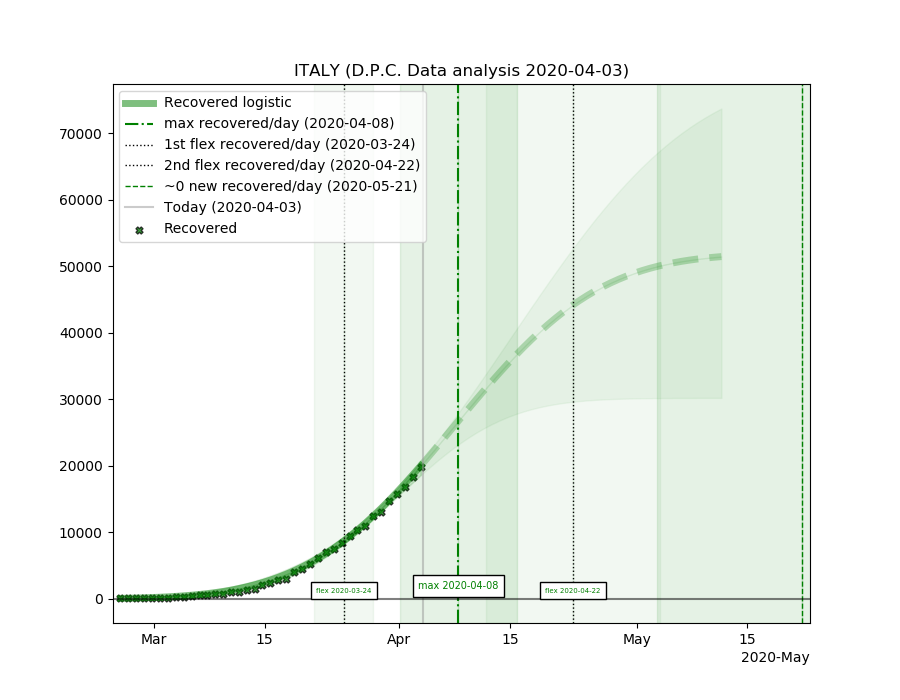

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. Data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noR) + dt.timedelta(days=1))

# original Rata points
ax.scatter(x, TOTyR, alpha=0.75, c="g",edgecolors='#000000', marker="X", s=25, label="Recovered")
# original Rata RotteR line
# ax.plot(x, TOTyR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitteR curve up to forecast limit
ax.plot(xg[:len(x)], logR[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0, label="Recovered logistic")
ax.plot(xg[len(x) - 1:], logR[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logR[:len(x)], logRsup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], logR[len(x) - 1:], logRsup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], logR[:len(x)], logRinf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], logR[len(x) - 1:], logRinf[len(x) - 1:], alpha=0.05, color="g")

# maximum and flexes
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
ax.axvspan(muR, muRsup, alpha=0.1, color="g")
ax.axvspan(muR, muRinf, alpha=0.1, color="g")
plt.text(muR, ymuR, "max " + muR.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f1R, linestyle=":", color="k", label="1st flex recovered/day ({})".format(f1R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1R, f1Rsup, alpha=0.05, color="g")
ax.axvspan(f1R, f1Rinf, alpha=0.05, color="g")
plt.text(f1R, yf1R, "flex " + f1R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f2R, linestyle=":", color="k", label="2nd flex recovered/day ({})".format(f2R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2R, f2Rsup, alpha=0.05, color="g")
ax.axvspan(f2R, f2Rinf, alpha=0.05, color="g")
plt.text(f2R, yf2R, "flex " + f2R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

# ~0 recovered/day date vertical line 
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))
ax.axvspan(noR, noRsup, alpha=0.1, color="g")
ax.axvspan(noR, noRinf, alpha=0.1, color="g")

# TORAY Rate grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGENR
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


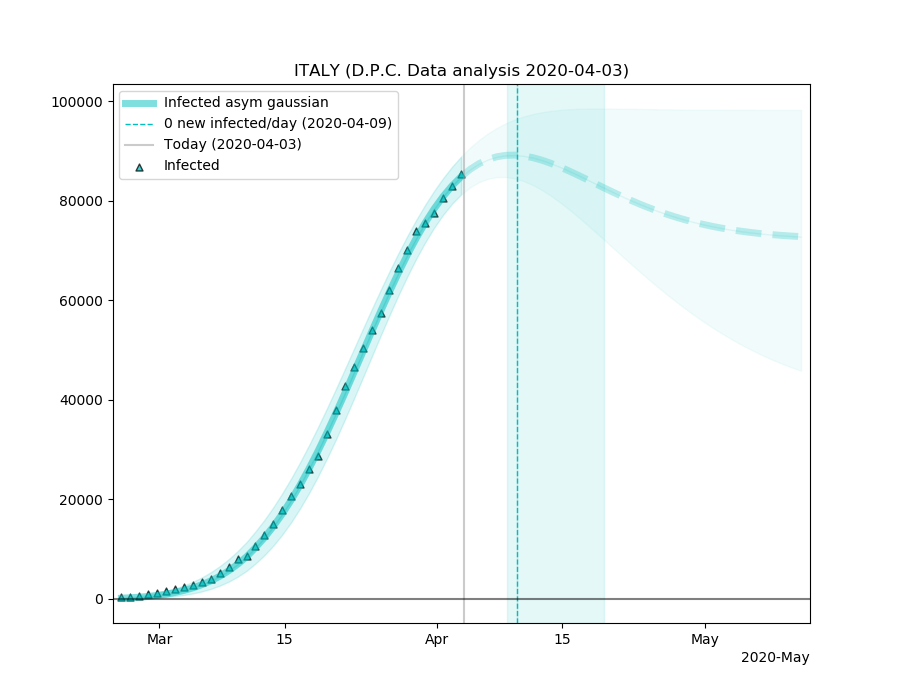

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. Data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original Pata points
ax.scatter(x, TOTyP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="Infected")
# original Pata PotteP line
# ax.plot(x, TOTyP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitteP curve up to forecast limit
ax.plot(xg[:len(x)], logP[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0, label="Infected asym gaussian")
ax.plot(xg[len(x) - 1:], logP[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logP[:len(x)], logPsup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], logP[len(x) - 1:], logPsup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], logP[:len(x)], logPinf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], logP[len(x) - 1:], logPinf[len(x) - 1:], alpha=0.05, color="c")

# ~0 infected/day date vertical line 
plt.axvline(x=x0P, color="c", linestyle="--", linewidth=1.0, label="0 new infected/day ({})".format(x0P.strftime("%Y-%m-%d")))
ax.axvspan(x0P, x0Psup, alpha=0.1, color="c")
ax.axvspan(x0P, x0Pinf, alpha=0.1, color="c")

# TOPAY Pate grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGENP
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


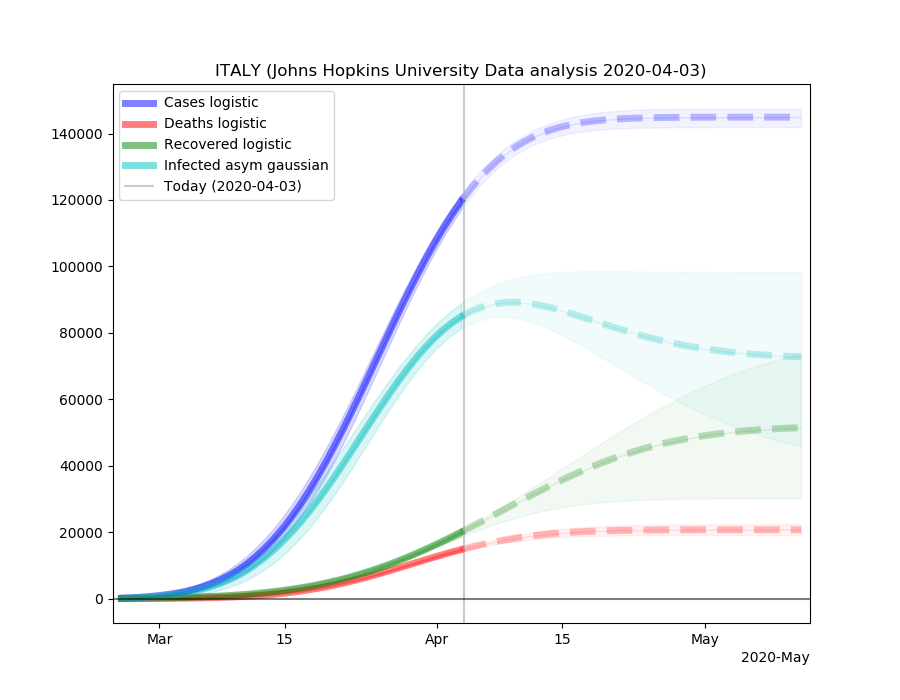

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (Johns Hopkins University Data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

ax.plot(xg[:len(x)], logC[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0, label="Cases logistic")
ax.plot(xg[len(x) - 1:], logC[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logC[:len(x)], logCsup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], logC[len(x) - 1:], logCsup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], logC[:len(x)], logCinf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], logC[len(x) - 1:], logCinf[len(x) - 1:], alpha=0.05, color="b")

ax.plot(xg[:len(x)], logD[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0, label="Deaths logistic")
ax.plot(xg[len(x) - 1:], logD[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logD[:len(x)], logDsup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], logD[len(x) - 1:], logDsup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], logD[:len(x)], logDinf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], logD[len(x) - 1:], logDinf[len(x) - 1:], alpha=0.05, color="r")

ax.plot(xg[:len(x)], logR[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0, label="Recovered logistic")
ax.plot(xg[len(x) - 1:], logR[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logR[:len(x)], logRsup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], logR[len(x) - 1:], logRsup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], logR[:len(x)], logRinf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], logR[len(x) - 1:], logRinf[len(x) - 1:], alpha=0.05, color="g")

ax.plot(xg[:len(x)], logP[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0, label="Infected asym gaussian")
ax.plot(xg[len(x) - 1:], logP[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], logP[:len(x)], logPsup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], logP[len(x) - 1:], logPsup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], logP[:len(x)], logPinf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], logP[len(x) - 1:], logPinf[len(x) - 1:], alpha=0.05, color="c")

# TOPAY Pate grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGENP
plt.legend(loc='upper left', fontsize='medium')
plt.show()